In [13]:
%load_ext autoreload
%autoreload 2

import os
from time import time
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

import softclustering as sc
import socceraction.spadl as spadl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
datafolder = "data"
fifa2018h5 = os.path.join(datafolder, "spadl-fifa2018.h5")
games = pd.read_hdf(fifa2018h5, key="games")
with pd.HDFStore(fifa2018h5) as store:
    actions = []  #list of DataFrames
    for game in tqdm(games.itertuples()):
        game_action = store[f"actions/game_{game.game_id}"]
        game_action = spadl.play_left_to_right(game_action, game.home_team_id)
        game_action["is_home"] = game_action["team_id"] == game.home_team_id
        actions.append(game_action)
    actions = pd.concat(actions)
    actions.drop("original_event_id", axis=1, inplace=True)
    actions = pd.merge(actions, spadl.config.actiontypes_df(), how="left")
    actions = sc.consolidate(actions)
    actions = sc.add_noise(actions)
    actions = sc.remove_outliers(actions, True)
    actions["angle"] = np.arctan2(actions.end_y - actions.start_y, actions.end_x - actions.start_x)
    actions["cos_angle"] = np.cos(actions["angle"])
    actions["sin_angle"] = np.sin(actions["angle"])

64it [00:00, 217.14it/s]


Remove 583 out of 128484 datapoints.


In [3]:
n_obs_pass = len(actions[actions["type_name"] == "pass"])
n_obs_array = [int(n_obs_pass // 10 ** i) for i in range(3, -1, -1)]
n_obs_array

[56, 562, 5620, 56204]

In [4]:
rows = []

init = "k-means"
mask = (actions["type_name"] == "pass")
loc_data = actions.loc[mask, ["start_x", "start_y"]]
dir_data = actions.loc[mask, ["cos_angle", "sin_angle"]]
K_loc = 10
K_dir = [3 for _ in range(K_loc)]

for n_obs in n_obs_array:
    for tol in [1e-2]:
        for method in ["bregman", "approximation", "classic"]:

            # Two-layer Model
            loc_mixture = sc.MixtureModel(
                [sc.MultivariateGaussian() for _ in range(K_loc)],
                init=init,
                rng=10,
            )
            dir_mixtures = [sc.MixtureModel(
                [sc.VonMises() for _ in range(K_dir[j])],
                init=init,
                rng=j,
            )
                for j in range(K_loc)]


            model = sc.TwoLayerScheme(loc_mixture, dir_mixtures)
            start = time()
            model.fit(loc_data.iloc[:n_obs],
                      dir_data.iloc[:n_obs],
                      case=method,
                      tol=1e-2,
                      verbose=False)
            end_tl = round(time() - start, 4)
            bic_score_tl = round(model.bic_score(loc_data, dir_data), 2)

            # One-shot Model
            model = sc.OneShotScheme(n_clusters=3 * K_loc,
                                     alpha=1,
                                     beta=1,
                                     init=init)

            start = time()
            model.fit(loc_data.iloc[:n_obs],
                      dir_data.iloc[:n_obs],
                      case=method,
                      tol=1e-2,
                      verbose=False)
            end_os = round(time() - start, 4)
            bic_score_os = round(model.bic_score(loc_data, dir_data), 2)

            # Annotate
            row = {
                "n_Obs": n_obs,
                "Tol": tol,
                "Method": method,
                "BIC Score TL": bic_score_tl,
                "BIC Score OS": bic_score_os,
                "Running Time TL": end_tl,
                "Running Time OS": end_os,
            }
            print(f" {n_obs}, {tol}, {method}, Two-layer: {end_tl}s, One-shot: {end_os}s.")
            rows.append(row)

experiment_df = pd.DataFrame(rows)


 56, 0.01, bregman, Two-layer: 0.3952s, One-shot: 0.1603s.
 56, 0.01, approximation, Two-layer: 0.3399s, One-shot: 0.1245s.
 56, 0.01, classic, Two-layer: 0.4305s, One-shot: 0.2141s.
 562, 0.01, bregman, Two-layer: 0.4255s, One-shot: 0.2031s.
 562, 0.01, approximation, Two-layer: 0.6184s, One-shot: 0.2438s.
 562, 0.01, classic, Two-layer: 1.0601s, One-shot: 0.3486s.
 5620, 0.01, bregman, Two-layer: 3.8144s, One-shot: 0.4722s.
 5620, 0.01, approximation, Two-layer: 4.1106s, One-shot: 0.4489s.
 5620, 0.01, classic, Two-layer: 5.3177s, One-shot: 0.8609s.
 56204, 0.01, bregman, Two-layer: 33.2779s, One-shot: 2.3549s.
 56204, 0.01, approximation, Two-layer: 19.4826s, One-shot: 1.893s.
 56204, 0.01, classic, Two-layer: 64.4996s, One-shot: 2.6598s.


In [5]:
experiment_df

,n_Obs,Tol,Method,BIC Score TL,BIC Score OS,Running Time TL,Running Time OS
0,56,0.01,bregman,2143760.16,4393438.41,0.3952,0.1603
1,56,0.01,approximation,2156590.52,4422766.39,0.3399,0.1245
2,56,0.01,classic,2144109.24,4387751.35,0.4305,0.2141
3,562,0.01,bregman,1191659.24,1211609.69,0.4255,0.2031
4,562,0.01,approximation,1192229.37,1212249.99,0.6184,0.2438
5,562,0.01,classic,1191724.49,1211671.38,1.0601,0.3486
6,5620,0.01,bregman,1174852.06,1171720.39,3.8144,0.4722
7,5620,0.01,approximation,1174526.77,1171696.55,4.1106,0.4489
8,5620,0.01,classic,1174824.72,1171713.66,5.3177,0.8609
9,56204,0.01,bregman,1168058.22,1169274.52,33.2779,2.3549


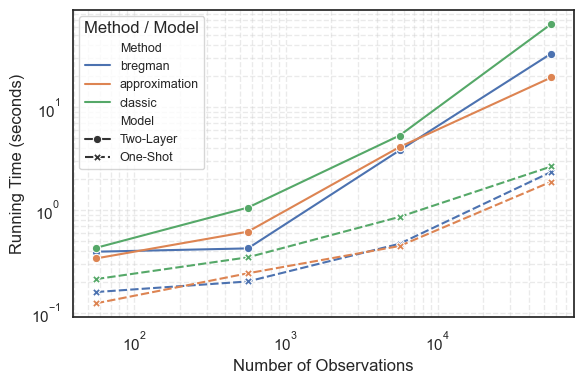

In [6]:
df = experiment_df[experiment_df["Tol"] == 0.01].melt(
    id_vars=["n_Obs", "Method"],
    value_vars=["Running Time TL", "Running Time OS"],
    var_name="Model",
    value_name="Running Time"
)

# Rename method labels
df["Model"] = df["Model"].map({
    "Running Time TL": "Two-Layer",
    "Running Time OS": "One-Shot"
})

plt.figure(figsize=(6,4))
sns.lineplot(
    data=df,
    x="n_Obs",
    y="Running Time",
    hue="Method",
    style="Model",
    markers=True
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of Observations")
plt.ylabel("Running Time (seconds)")
#plt.title("Running Time vs. Sample Size by Model")
plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.legend(title="Method / Model", loc="best", fontsize=9,)
plt.tight_layout()
#plt.savefig("plots/time_dataset.pdf")
plt.show()


## Synthetic data

In [7]:
def sim_data(N):
    val = []
    vm_mu = [0.0, np.pi / 3, np.pi]
    vm_kappa = [3.5, 0.8, 1.0]
    vm_syn = np.empty(shape=(N, 2))
    gauss_syn = np.empty(shape=(N, 2))
    index = 0

    for i, num in enumerate(np.random.multinomial(N, loc_mixture.weights)):
        mean, cov = loc_mixture.components[i].params
        gauss = np.random.multivariate_normal(mean, cov, size=num)
        gauss_syn[index:num + index, :] = gauss
        for j, num_vm in enumerate(np.random.multinomial(num, [0.3, 0.6, 0.1])):
            von_mises_angle = np.random.vonmises(mu=vm_mu[j] + np.random.uniform(0, 1, 1),
                                                 kappa=vm_kappa[j] + np.random.uniform(0, 0.1, 1),
                                                 size=num_vm)
            cos = np.cos(von_mises_angle)
            sin = np.sin(von_mises_angle)
            vm_syn[index:num_vm + index, :] = np.column_stack([cos, sin])
            index += num_vm

    syn_data = np.column_stack([gauss_syn, vm_syn])
    np.random.shuffle(syn_data)
    return syn_data

def experiment(n_obs_array, syn_data, methods = ("bregman", "approximation", "classic")):
    rows = []
    for n_obs in n_obs_array:
        for tol in [1e-2]:
            for method in methods:

                # Two-layer Model
                loc_mixture = sc.MixtureModel(
                    [sc.MultivariateGaussian() for _ in range(K_loc)],
                    init=init,
                    rng=10,
                )
                dir_mixtures = [sc.MixtureModel(
                    [sc.VonMises() for _ in range(K_dir[j])],
                    init=init,
                    rng=j,
                )
                    for j in range(K_loc)]


                model = sc.TwoLayerScheme(loc_mixture, dir_mixtures)
                start = time()
                model.fit(syn_data[:n_obs, :2],
                          syn_data[:n_obs, 2:],
                          case=method,
                          tol=1e-2,
                          verbose=False)
                end_tl = round(time() - start, 4)
                bic_score_tl = round(model.bic_score(syn_data[:n_obs, :2],
                                                     syn_data[:n_obs, 2:]), 2)

                # One-shot Model
                model = sc.OneShotScheme(n_clusters=3 * K_loc,
                                         alpha=1,
                                         beta=1,
                                         init=init)

                start = time()
                model.fit(syn_data[:n_obs, :2],
                          syn_data[:n_obs, 2:],
                          case=method,
                          tol=1e-2,
                          verbose=False)
                end_os = round(time() - start, 4)
                bic_score_os = round(model.bic_score(syn_data[:n_obs, :2],
                                                     syn_data[:n_obs, 2:]), 2)

                # Annotate
                row = {
                    "n_Obs": n_obs,
                    "Tol": tol,
                    "Method": method,
                    "BIC Score TL": bic_score_tl,
                    "BIC Score OS": bic_score_os,
                    "Running Time TL": end_tl,
                    "Running Time OS": end_os,
                }
                print(f" {n_obs}, {tol}, {method}, Two-layer: {end_tl}s, One-shot: {end_os}s.")
                rows.append(row)

        experiment_syn_df = pd.DataFrame(rows)

        df = experiment_syn_df[experiment_syn_df["Tol"] == 0.01].melt(
            id_vars=["n_Obs", "Method"],
            value_vars=["Running Time TL", "Running Time OS"],
            var_name="Model",
            value_name="Running Time"
        )

        # Rename method labels
        df["Model"] = df["Model"].map({
            "Running Time TL": "Two-Layer",
            "Running Time OS": "One-Shot"
        })

        plt.figure(figsize=(6,4))
        sns.lineplot(
            data=df,
            x="n_Obs",
            y="Running Time",
            hue="Method",
            style="Model",
            markers=True
        )

        plt.xscale("log")
        plt.yscale("log")
        plt.xlabel("Number of Observations")
        plt.ylabel("Running Time (seconds)")
        #plt.title("Running Time vs. Sample Size by Model")
        plt.grid(True, which="both", linestyle="--", alpha=0.4)
        plt.legend(title="Method / Model", loc="best", fontsize=9,)
        plt.tight_layout()
        plt.savefig("plots/time_synthetic.pdf")
        #plt.show()
        plt.close()

    return pd.DataFrame(rows)


In [8]:
init = "k-means"
K_loc = 5
K_dir = [3 for _ in range(K_loc)]

N = 10_485_999
syn_data = sim_data(N)
n_obs_array = []
i = 20
while i < N:
    n_obs_array.append(i)
    i = int(i*2)

print(n_obs_array)


[20, 40, 80, 160, 320, 640, 1280, 2560, 5120, 10240, 20480, 40960, 81920, 163840, 327680, 655360, 1310720, 2621440, 5242880, 10485760]


In [9]:
experiment_syn_df = experiment(n_obs_array, syn_data, methods = ("bregman", "approximation", "classic"))
# Expected Time: 10hrs 30min

 20, 0.01, bregman, Two-layer: 0.145s, One-shot: 0.0888s.
 20, 0.01, approximation, Two-layer: 0.1512s, One-shot: 0.0829s.
 20, 0.01, classic, Two-layer: 0.2432s, One-shot: 0.1162s.
 40, 0.01, bregman, Two-layer: 0.2708s, One-shot: 0.0831s.
 40, 0.01, approximation, Two-layer: 0.1307s, One-shot: 0.0542s.
 40, 0.01, classic, Two-layer: 0.3298s, One-shot: 0.1135s.
 80, 0.01, bregman, Two-layer: 0.318s, One-shot: 0.0582s.
 80, 0.01, approximation, Two-layer: 0.2394s, One-shot: 0.0569s.
 80, 0.01, classic, Two-layer: 0.3668s, One-shot: 0.3s.
 160, 0.01, bregman, Two-layer: 0.1988s, One-shot: 0.0813s.
 160, 0.01, approximation, Two-layer: 0.3131s, One-shot: 0.0642s.
 160, 0.01, classic, Two-layer: 0.42s, One-shot: 0.9238s.
 320, 0.01, bregman, Two-layer: 0.4509s, One-shot: 0.3106s.
 320, 0.01, approximation, Two-layer: 0.4524s, One-shot: 0.1232s.
 320, 0.01, classic, Two-layer: 0.4373s, One-shot: 0.2366s.
 640, 0.01, bregman, Two-layer: 0.3534s, One-shot: 0.1586s.
 640, 0.01, approximation,

In [16]:
experiment_syn_df

,n_obs,tol,model,bic_score,running_time
0,10,0.01,bregman,5695900,0.0498
1,10,0.01,approximation,5708919,0.0436
2,10,0.01,classic,5695902,0.0878
3,20,0.01,bregman,1958464,0.0398
4,20,0.01,approximation,1966336,0.0333
...,...,...,...,...,...
123,800000,0.01,approximation,1211744,444.4027
124,900000,0.01,bregman,1212763,118.0705
125,900000,0.01,approximation,1211951,750.3142
126,1000000,0.01,bregman,1203146,388.0165


In [18]:
experiment_syn_df = pd.read_csv(
    "data/time_complexity.csv",
    header=None,
    names=["n_Obs", "Tol", "Method", "BIC Score TL", "BIC Score OS", "Running Time TL", "Running Time OS"]
)
experiment_syn_df

,n_Obs,Tol,Method,BIC Score TL,BIC Score OS,Running Time TL,Running Time OS
0,20,0.01,bregman,4.125100e+02,-9.857000e+01,0.1450,0.0888
1,20,0.01,approximation,4.124600e+02,-9.865000e+01,0.1512,0.0829
2,20,0.01,classic,4.125100e+02,-9.857000e+01,0.2432,0.1162
3,40,0.01,bregman,1.028860e+03,6.268000e+02,0.2708,0.0831
4,40,0.01,approximation,1.028760e+03,6.267900e+02,0.1307,0.0542
5,40,0.01,classic,1.028860e+03,6.268100e+02,0.3298,0.1135
6,80,0.01,bregman,1.921560e+03,1.830460e+03,0.3180,0.0582
7,80,0.01,approximation,1.920690e+03,1.830650e+03,0.2394,0.0569
8,80,0.01,classic,1.920600e+03,1.830440e+03,0.3668,0.3000
9,160,0.01,bregman,3.694650e+03,3.759200e+03,0.1988,0.0813


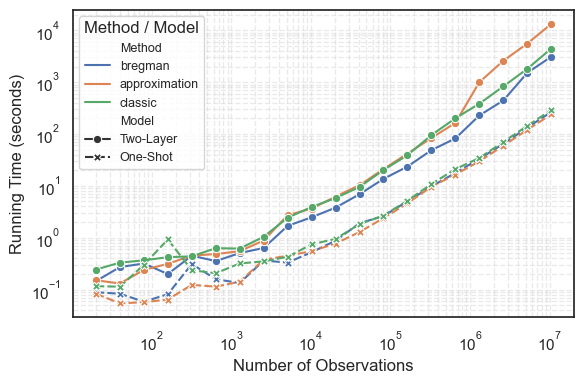

In [19]:
df = experiment_syn_df[experiment_syn_df["Tol"] == 0.01].melt(
    id_vars=["n_Obs", "Method"],
    value_vars=["Running Time TL", "Running Time OS"],
    var_name="Model",
    value_name="Running Time"
)

# Rename method labels
df["Model"] = df["Model"].map({
    "Running Time TL": "Two-Layer",
    "Running Time OS": "One-Shot"
})

plt.figure(figsize=(6,4))
sns.lineplot(
    data=df,
    x="n_Obs",
    y="Running Time",
    hue="Method",
    style="Model",
    markers=True
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of Observations")
plt.ylabel("Running Time (seconds)")
#plt.title("Running Time vs. Sample Size by Model")
plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.legend(title="Method / Model", loc="best", fontsize=9,)
plt.tight_layout()
#plt.savefig("plots/time_synthetic.pdf")
plt.show()
